In [41]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, roc_curve, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

Please note, this dataset was to big to be included n the repository, it can be found at https://www.kaggle.com/mlg-ulb/creditcardfraud. 

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
creditcard = pd.read_csv('../creditcard.csv')
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,...,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,...,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,...,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0
3,1.000,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,...,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.500,0
4,2.000,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,...,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.990,0


This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation.

Standardising and splitting data

In [6]:
X = creditcard.drop('Class', axis='columns').to_numpy().reshape(-1,30)
y = creditcard['Class'].to_numpy()

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y)

Fitting an SVM and RandomForest classifiers

In [10]:
clf_svm = svm.SVC(C=1, probability=True)
clf_svm.fit(X_train,y_train)

SVC(C=1, probability=True)

In [11]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train,y_train)

RandomForestClassifier()

Acquiring preditions

In [12]:
yp_svm = clf_svm.predict(X_test)

In [13]:
yp_rf = clf_rf.predict(X_test)

Obtaining  FPRs and TPRs for both models using roc_curve. Plotting those curves and visualising confusion matrices

In [14]:
svm_fpr, svm_tpr, svm_threshold = roc_curve(y_test, yp_svm)

rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, yp_rf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71067
           1       0.99      0.71      0.83       135

    accuracy                           1.00     71202
   macro avg       0.99      0.86      0.91     71202
weighted avg       1.00      1.00      1.00     71202



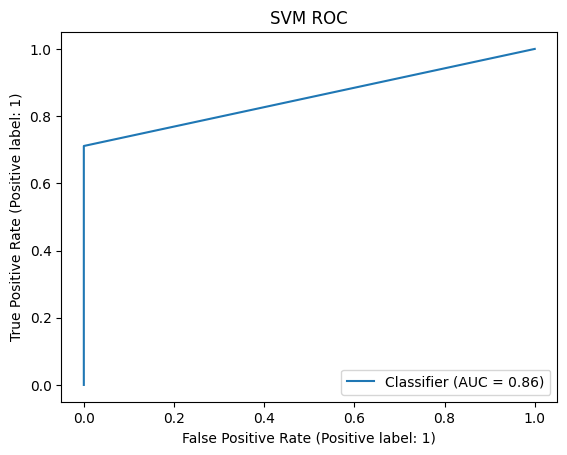

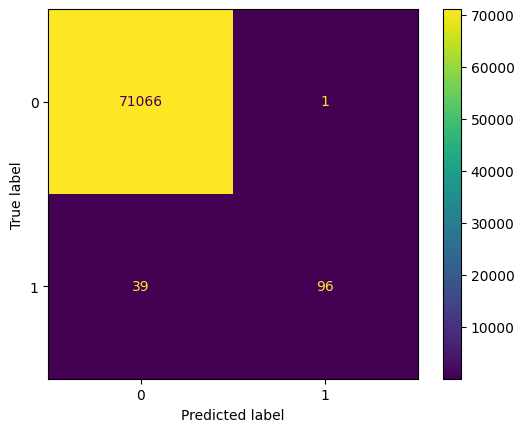

In [28]:
RocCurveDisplay(fpr=svm_fpr, tpr=svm_tpr).from_predictions(y_test, yp_svm)
plt.title("SVM ROC")
ConfusionMatrixDisplay.from_predictions(y_test, yp_svm)
print(classification_report(y_test, yp_svm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71067
           1       0.97      0.82      0.89       135

    accuracy                           1.00     71202
   macro avg       0.99      0.91      0.95     71202
weighted avg       1.00      1.00      1.00     71202



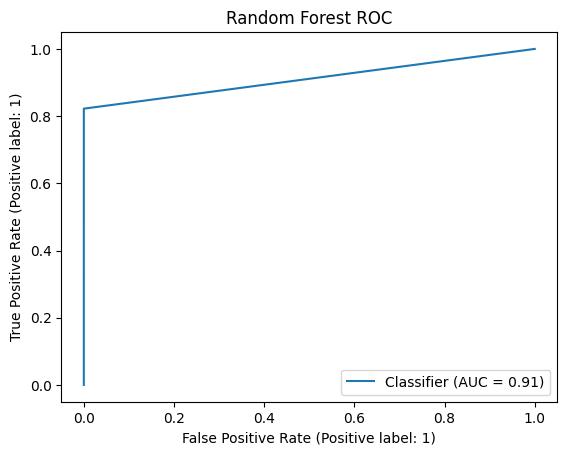

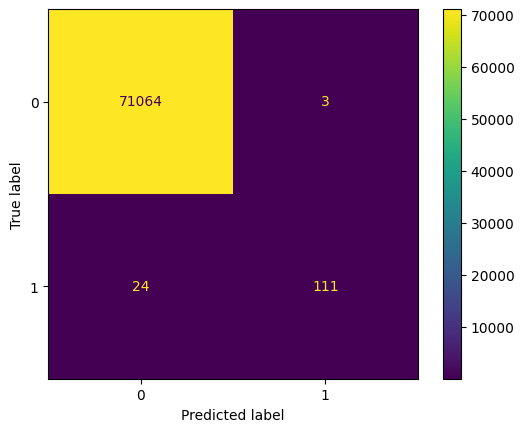

In [29]:
RocCurveDisplay(fpr=rf_fpr, tpr=rf_tpr).from_predictions(y_test, yp_rf)
plt.title("Random Forest ROC");
ConfusionMatrixDisplay.from_predictions(y_test, yp_rf)
print(classification_report(y_test, yp_rf))

Going forward Random Forest will be used

Obtaining precision, recall and f1 scores for different probability thresholds and plotting them

In [30]:
thresholds = np.arange(0.005, 0.2, 0.01)
precision = []
recall = []
f1 = []

for threshold in thresholds:
    y_proba_rf = clf_rf.predict_proba(X_test)[:,1]
    y_predicted = y_proba_rf > threshold

    clf_rep = classification_report(y_test, y_predicted, output_dict=True)
    
    precision.append(clf_rep['1']['precision'])
    recall.append(clf_rep['1']['recall'])
    f1.append(clf_rep['1']['f1-score'])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71067
           1       0.81      0.90      0.85       135

    accuracy                           1.00     71202
   macro avg       0.91      0.95      0.93     71202
weighted avg       1.00      1.00      1.00     71202



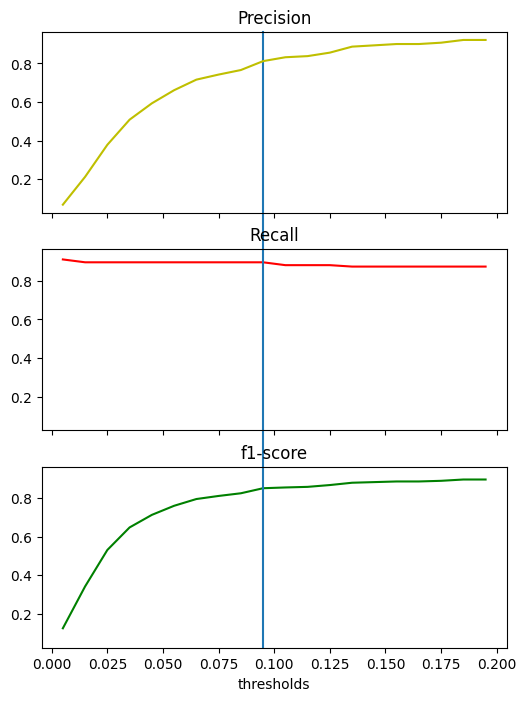

In [33]:
fig, axs = plt.subplots(3,1, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(6)

axs[0].plot(thresholds,precision, color='y')
axs[0].set_title('Precision')

axs[1].plot(thresholds,recall, color='r')
axs[1].set_title('Recall')

axs[2].plot(thresholds,f1, color='g')
axs[2].set_title('f1-score')
axs[2].set_xlabel('thresholds')

optimal_threshold = 0.095

axs[0].axvline(x=optimal_threshold, ymax = 1, ymin = -2, clip_on = False, zorder = -1)
axs[1].axvline(x=optimal_threshold)
axs[2].axvline(x=optimal_threshold)

y_proba_rf = clf_rf.predict_proba(X_test)[:,1]
y_predicted = y_proba_rf > optimal_threshold

print(classification_report(y_test, y_predicted))

Confusion matrix for probablity threshold at 0.095. As we can see some False Negatives were caught and there are a lot more False Positives which was to be expected, however for this kind of a problem it is most important to reduce the number of False Negatives, which in this case would be fraudulent transactions misclasified as normal.

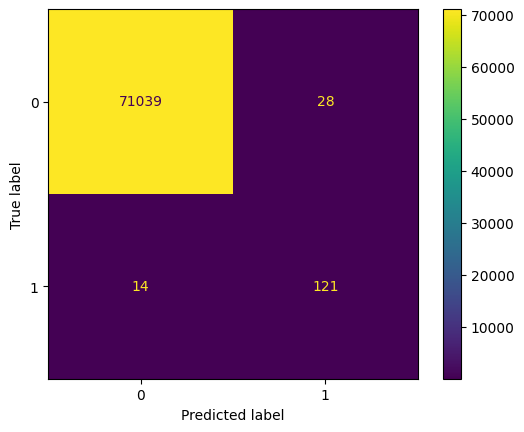

In [34]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted);

Using undersampling to further improve Recall

In [44]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [46]:
clf_rf_rus = RandomForestClassifier()
clf_rf_rus.fit(X_resampled,y_resampled)

RandomForestClassifier()

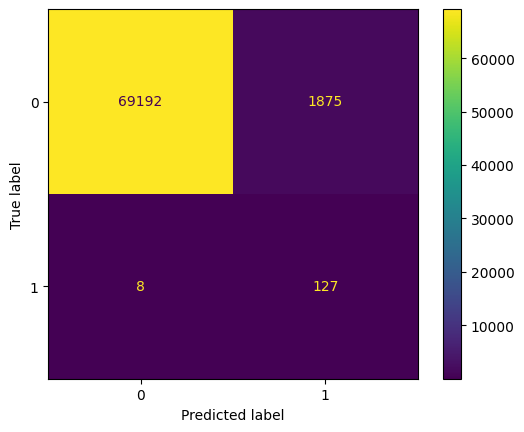

In [48]:
y_pred_resampled = clf_rf_rus.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_resampled);

Recall has been imporved at a high cost of precision. In this case it could be debated at which level to actually set the thresholds and how much precision can we sacrifice in order to catch as many fraudulent cases as possible.